In [12]:
import pandas as pd
import sgs
import numpy as np

# Lista das séries e descrições
series_info = [
    {'code': 21005, 'description': 'Percentual da carteira de crédito com atraso entre 15 e 90 dias - Pessoas físicas - Total - %'},
    {'code': 21084, 'description': 'Inadimplência da carteira de crédito - Pessoas físicas - Total - %'},
    {'code': 20541, 'description': 'Saldo da carteira de crédito - Pessoas físicas - Total - R$ (milhões)'},
    {'code': 20633, 'description': 'Concessões de crédito - Pessoas físicas - Total - R$ (milhões)'},
    {'code': 20716, 'description': 'Taxa média de juros das operações de crédito - Pessoas físicas - Total - % a.a.'},
    {'code': 25353, 'description': 'Indicador de Custo do Crédito - ICC - Pessoas físicas - Total - % a.a.'},
    {'code': 27445, 'description': 'Spread do ICC - Pessoas físicas - Total - p.p.'},
]

In [13]:
# Carregar dados
df = pd.DataFrame()

for series in series_info:
    ts = sgs.dataframe(series['code'], start='01/01/2013', end='31/12/2024')
    df = df.join(ts, how='right')

display(df)

,21005,21084,20541,20633,20716,25353,27445
2013-01-01,5.75,5.03,1088275.0,112632.0,27.38,25.70,18.79
2013-02-01,5.97,4.98,1094775.0,102793.0,27.96,25.93,19.03
2013-03-01,6.11,4.94,1108015.0,111957.0,27.42,25.62,18.78
2013-04-01,5.98,4.85,1124846.0,123133.0,27.21,25.35,18.57
2013-05-01,5.68,4.88,1143984.0,124531.0,26.93,24.99,18.30
...,...,...,...,...,...,...,...
2024-05-01,5.40,3.69,3674815.0,329443.0,32.52,25.34,18.42
2024-06-01,5.14,3.64,3704905.0,313750.0,32.53,25.41,18.44
2024-07-01,5.00,3.70,3744228.0,349192.0,32.40,25.29,18.31
2024-08-01,5.13,3.76,3767996.0,342899.0,32.14,25.36,18.34


In [14]:
df.index = pd.to_datetime(df.index)

modelo_ativo_df = pd.DataFrame()
modelo_ativo_df['Data'] = df.index

modelo_ativo_df.set_index('Data', inplace=True)
modelo_ativo_df = modelo_ativo_df.reindex(df.index)

# 1. Saldo Carteira de Crédito PF
modelo_ativo_df['Saldo Carteira de Crédito PF'] = df[20541]

# 2. Taxa Empréstimos
modelo_ativo_df['Taxa Empréstimos'] = df[20716] / 100

# 3. Inadimplência 60
modelo_ativo_df['Inadimplência 60'] = (df[21005] + df[21084]) / 200

# 4. Inadimplência 90
modelo_ativo_df['Inadimplência 90'] = df[21084] / 100

# 5. Concessões
modelo_ativo_df['Concessões'] = df[20633]

# 6. Reembolsos+Write-Offs with the corrected formula
modelo_ativo_df['Saldo Carteira de Crédito PF_t-12'] = modelo_ativo_df['Saldo Carteira de Crédito PF'].shift(12)
modelo_ativo_df['Taxa Empréstimos_t-12'] = modelo_ativo_df['Taxa Empréstimos'].shift(12)
modelo_ativo_df['Inadimplência 60_t-12'] = modelo_ativo_df['Inadimplência 60'].shift(12)

modelo_ativo_df['Reembolsos+Write-Offs'] = (
    modelo_ativo_df['Saldo Carteira de Crédito PF_t-12'] * 
    (1 + modelo_ativo_df['Taxa Empréstimos_t-12'] * (1 - modelo_ativo_df['Inadimplência 60_t-12'])) +
    modelo_ativo_df['Concessões'] -
    modelo_ativo_df['Saldo Carteira de Crédito PF']
)

# 7. Reembolso
modelo_ativo_df['Reembolso'] = modelo_ativo_df['Reembolsos+Write-Offs'] * 0.96

# 8. Write-Off
modelo_ativo_df['Write-Off'] = modelo_ativo_df['Reembolsos+Write-Offs'] - modelo_ativo_df['Reembolso']

# 9. Write-Off%
modelo_ativo_df['Write-Off%'] = modelo_ativo_df['Write-Off'] / modelo_ativo_df['Saldo Carteira de Crédito PF']

# 10. PCLD
modelo_ativo_df['PCLD'] = modelo_ativo_df['Saldo Carteira de Crédito PF'] * modelo_ativo_df['Inadimplência 90']

# 11. Migração PCLD
modelo_ativo_df['PCLD_t-1'] = modelo_ativo_df['PCLD'].shift(1)
modelo_ativo_df['Migração PCLD'] = modelo_ativo_df['PCLD'] - modelo_ativo_df['PCLD_t-1'] + modelo_ativo_df['Write-Off']

# 12. Migração PCLD (%)
modelo_ativo_df['Migração PCLD (%)'] = modelo_ativo_df['Migração PCLD'] / modelo_ativo_df['Saldo Carteira de Crédito PF']

# Limpeza de colunas temporárias
modelo_ativo_df.drop(columns=['Saldo Carteira de Crédito PF_t-12', 'Taxa Empréstimos_t-12', 'Inadimplência 60_t-12', 'PCLD_t-1'], inplace=True)


display(modelo_ativo_df)

,Saldo Carteira de Crédito PF,Taxa Empréstimos,Inadimplência 60,Inadimplência 90,Concessões,Reembolsos+Write-Offs,Reembolso,Write-Off,Write-Off%,PCLD,Migração PCLD,Migração PCLD (%)
2013-01-01,1088275.0,0.2738,0.05390,0.0503,112632.0,NaN,NaN,NaN,NaN,54740.2325,NaN,NaN
2013-02-01,1094775.0,0.2796,0.05475,0.0498,102793.0,NaN,NaN,NaN,NaN,54519.7950,NaN,NaN
2013-03-01,1108015.0,0.2742,0.05525,0.0494,111957.0,NaN,NaN,NaN,NaN,54735.9410,NaN,NaN
2013-04-01,1124846.0,0.2721,0.05415,0.0485,123133.0,NaN,NaN,NaN,NaN,54555.0310,NaN,NaN
2013-05-01,1143984.0,0.2693,0.05280,0.0488,124531.0,NaN,NaN,NaN,NaN,55826.4192,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,3674815.0,0.3252,0.04545,0.0369,329443.0,1.165696e+06,1.119068e+06,46627.820380,0.012688,135600.6735,48756.419080,0.013268
2024-06-01,3704905.0,0.3253,0.04390,0.0364,313750.0,1.101832e+06,1.057759e+06,44073.284031,0.011896,134858.5420,43331.152531,0.011696
2024-07-01,3744228.0,0.3240,0.04350,0.0370,349192.0,1.109500e+06,1.065120e+06,44380.009219,0.011853,138536.4360,48057.903219,0.012835
2024-08-01,3767996.0,0.3214,0.04445,0.0376,342899.0,1.133988e+06,1.088629e+06,45359.521888,0.012038,141676.6496,48499.735488,0.012871


In [15]:
matriz_migracao_df = pd.DataFrame(index=df.index)

# 2. Atraso 15-90 dias
matriz_migracao_df['Atraso 15-90 dias'] = df[21005] / 100

# 3. Atraso >90 dias
matriz_migracao_df['Atraso >90 dias'] = df[21084] / 100

# 4. Write-Off como proporção do saldo da carteira de crédito
matriz_migracao_df['Write-Off'] = modelo_ativo_df['Write-Off%']

# 1. Curso Normal
matriz_migracao_df['Curso Normal'] = 1 - (
    matriz_migracao_df['Atraso 15-90 dias'] + 
    matriz_migracao_df['Atraso >90 dias'] + 
    matriz_migracao_df['Write-Off']
)

matriz_migracao_df = matriz_migracao_df.fillna(0)

# Exibir a matriz de migração
display(matriz_migracao_df.head())

,Atraso 15-90 dias,Atraso >90 dias,Write-Off,Curso Normal
2013-01-01,0.0575,0.0503,0.0,0.0
2013-02-01,0.0597,0.0498,0.0,0.0
2013-03-01,0.0611,0.0494,0.0,0.0
2013-04-01,0.0598,0.0485,0.0,0.0
2013-05-01,0.0568,0.0488,0.0,0.0


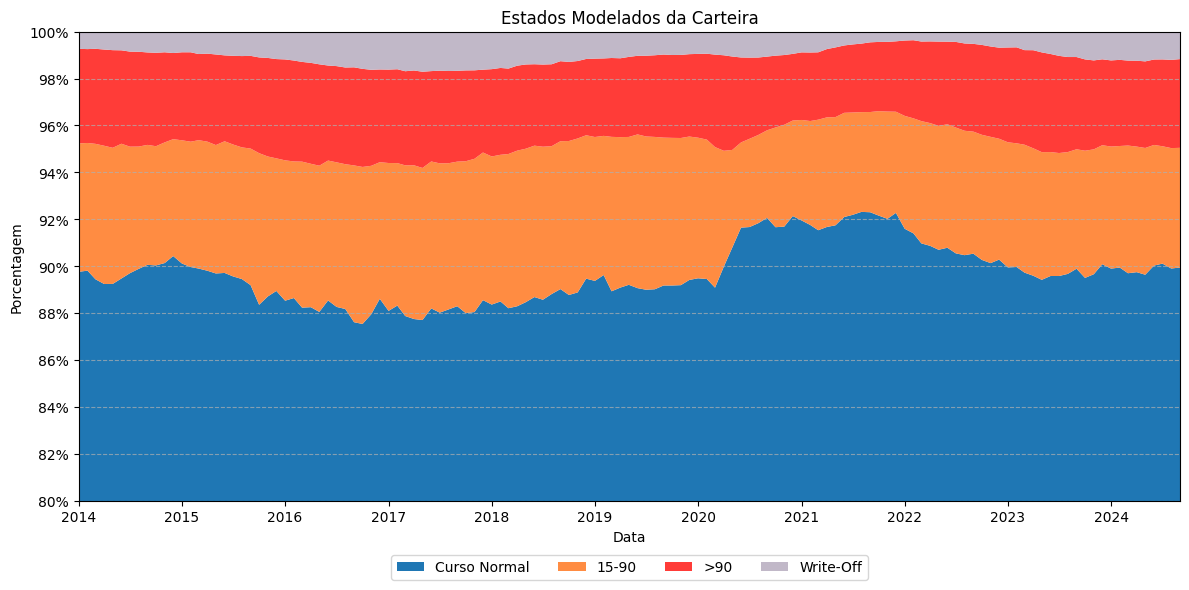

In [16]:
import matplotlib.pyplot as plt

# Filtro para começar em 2014
filtered_df = matriz_migracao_df[matriz_migracao_df.index >= '2014-01-01']


plt.figure(figsize=(12, 6))
plt.stackplot(
    filtered_df.index,
    filtered_df['Curso Normal'],
    filtered_df['Atraso 15-90 dias'],
    filtered_df['Atraso >90 dias'],
    filtered_df['Write-Off'],
    labels=['Curso Normal', '15-90', '>90', 'Write-Off'],
    colors=['#1f77b4', '#FF8C42', '#FF3C38', '#C1B8C8'] 
)

# Add labels and title
plt.title('Estados Modelados da Carteira')
plt.xlabel('Data')
plt.ylabel('Porcentagem')
plt.ylim(0.8, 1.0)  # Adjust y-axis range to 80%-100% if necessary
plt.yticks([i/100 for i in range(80, 101, 2)], [f"{i}%" for i in range(80, 101, 2)])
plt.xlim(filtered_df.index.min(), filtered_df.index.max())

# Show legend and grid
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [17]:
var_df = pd.DataFrame(index=modelo_ativo_df.index)

# 1. Saldo
var_df['Saldo'] = modelo_ativo_df['Saldo Carteira de Crédito PF']

# 2. Taxa de Juros
var_df['Taxa de Juros'] = modelo_ativo_df['Taxa Empréstimos']

# 3. Atraso 15-90 dias
var_df['15-90'] = modelo_ativo_df['Inadimplência 60']

# 4. Atraso >90 dias
var_df['>90'] = modelo_ativo_df['Inadimplência 90']

# 5. PCLD (Provisão para Créditos de Liquidação Duvidosa)
var_df['PCLD'] = modelo_ativo_df['PCLD']

# 6. DPCLD (variação da PCLD em 12 meses)
var_df['PCLD_t-12'] = var_df['PCLD'].shift(12)
var_df['DPCLD'] = var_df['PCLD'] - var_df['PCLD_t-12']

# 7. Retorno
# Retorno = (Saldo_t-12 * ((1 - 'Taxa de Juros'_t-12) * '15-90'_t-12) - PCLD) / Saldo
var_df['Saldo_t-12'] = var_df['Saldo'].shift(12)
var_df['Taxa de Juros_t-12'] = var_df['Taxa de Juros'].shift(12)
var_df['15-90_t-12'] = var_df['15-90'].shift(12)

var_df['Retorno'] = (var_df['Saldo_t-12'] * ((1 - var_df['15-90_t-12']) * var_df['Taxa de Juros_t-12']) - var_df['PCLD']) / var_df['Saldo_t-12']

# Remover colunas temporárias usadas para os cálculos com shift
var_df.drop(columns=['PCLD_t-12', 'Saldo_t-12', 'Taxa de Juros_t-12', '15-90_t-12'], inplace=True)
#var_df = var_df.fillna(0)

# Exibir o DataFrame resultante
display(var_df.head(20))

,Saldo,Taxa de Juros,15-90,>90,PCLD,DPCLD,Retorno
2013-01-01,1088275.0,0.2738,0.05390,0.0503,54740.2325,NaN,NaN
2013-02-01,1094775.0,0.2796,0.05475,0.0498,54519.7950,NaN,NaN
2013-03-01,1108015.0,0.2742,0.05525,0.0494,54735.9410,NaN,NaN
2013-04-01,1124846.0,0.2721,0.05415,0.0485,54555.0310,NaN,NaN
2013-05-01,1143984.0,0.2693,0.05280,0.0488,55826.4192,NaN,NaN
2013-06-01,1160114.0,0.2706,0.05170,0.0461,53481.2554,NaN,NaN
2013-07-01,1173994.0,0.2762,0.05130,0.0456,53534.1264,NaN,NaN
2013-08-01,1190495.0,0.2773,0.04920,0.0445,52977.0275,NaN,NaN
2013-09-01,1202447.0,0.2801,0.04970,0.0444,53388.6468,NaN,NaN
2013-10-01,1212482.0,0.2862,0.04885,0.0425,51530.4850,NaN,NaN


In [18]:
from scipy.optimize import minimize

# Corrected dates for the current and previous states
t_menos1 = '2023-08-01'  # previous state
t_0 = '2024-08-01'       # current state

# Define the correct order for the columns
order = ["Curso Normal", "Atraso 15-90 dias", "Atraso >90 dias", "Write-Off"]

# Reorder estado_t_menos1 and estado_t_0 according to the correct order
estado_t_menos1 = matriz_migracao_df.loc[t_menos1][order].values
estado_t_0 = matriz_migracao_df.loc[t_0][order].values

# Initialize the transition matrix as zeros (4x4 flattened to a 16-element array)
transicao_initial = np.zeros(16)

# Define the objective function to minimize the difference
def objective_function(transicao_flat):
    transicao = transicao_flat.reshape((4, 4))
    migracao = estado_t_menos1 @ transicao - estado_t_0
    return np.sum(migracao**2)  # minimize squared error

# Define constraints: specific elements set to 0 and each row summing to 1
constraints = [
    {'type': 'eq', 'fun': lambda transicao_flat: transicao_flat[3*4 + 0]},  # transicao_41 = 0
    {'type': 'eq', 'fun': lambda transicao_flat: transicao_flat[3*4 + 1]},  # transicao_42 = 0
    {'type': 'eq', 'fun': lambda transicao_flat: transicao_flat[0*4 + 3]},  # transicao_14 = 0
    {'type': 'eq', 'fun': lambda transicao_flat: transicao_flat[1*4 + 3]},  # transicao_24 = 0
]

# Add row sum constraints to ensure each row sums to 1
for i in range(4):
    constraints.append({'type': 'eq', 'fun': lambda transicao_flat, i=i: np.sum(transicao_flat[i*4:(i+1)*4]) - 1})

# Solve the optimization problem
result = minimize(objective_function, transicao_initial, constraints=constraints, method='SLSQP')

# Display the optimized transition matrix
if result.success:
    transicao_optimized = result.x.reshape((4, 4))
    print("Matriz de migração:\n", transicao_optimized)
else:
    print("A otimização falhou:", result.message)

# Calculate the predicted future state (futuro) by applying the matrix to estado_t_0
futuro = estado_t_0 @ transicao_optimized
print("Estado futuro estimado (aplicando a matriz em t0):", futuro)

# Calculate the difference
diff = futuro - estado_t_0
print("Diferença em relação ao estado atual (t0):", diff)

# Financial impact calculation based on `diff`
financial_impact = diff * var_df.loc[t_0, 'Saldo']
print("Impacto Financeiro esperado em 12 meses: ", financial_impact)

Matriz de migração:
 [[0.96725121 0.02729237 0.00545641 0.        ]
 [0.37002124 0.31562125 0.3143575  0.        ]
 [0.28591623 0.24346537 0.24247921 0.22813918]
 [0.         0.         0.50191865 0.49808135]]
Estado futuro estimado (aplicando a matriz em t0): [0.89935125 0.0498832  0.03619156 0.01457399]
Diferença em relação ao estado atual (t0): [ 0.00028935 -0.0014168  -0.00140844  0.00253589]
Impacto Financeiro esperado em 12 meses:  [ 1090.28335614 -5338.49099877 -5306.99748399  9555.20512662]


In [19]:
# Escolha o nível de confiança para o VaR
confidence_level = 0.95

# Calcule o percentil correspondente (por exemplo, para 95% de confiança, pegamos o 5º percentil)
var_value = np.percentile(var_df['Retorno'].dropna(), (1 - confidence_level) * 100)

print(f"VaR histórico no nível de confiança de {int(confidence_level * 100)}%: {var_value:.2%}")

VaR histórico no nível de confiança de 95%: 19.09%


In [20]:
from scipy.stats import norm

# Defina o nível de confiança
confidence_level = 0.95

# Calcule a média e o desvio padrão dos retornos
media_retorno = var_df['Retorno'].dropna().mean()
desvio_padrao_retorno = var_df['Retorno'].dropna().std()

# Obtenha o valor crítico da distribuição normal para o nível de confiança
z_score = norm.ppf(1 - confidence_level)

# Calcule o VaR paramétrico
var_parametrico = media_retorno - (desvio_padrao_retorno * z_score)

print(f"VaR Paramétrico no nível de confiança de {int(confidence_level * 100)}%: {var_parametrico:.2%}")

VaR Paramétrico no nível de confiança de 95%: 34.05%


count    129.000000
mean       0.262391
std        0.047486
min        0.182389
25%        0.230065
50%        0.251387
75%        0.302454
max        0.360755
Name: Retorno, dtype: float64


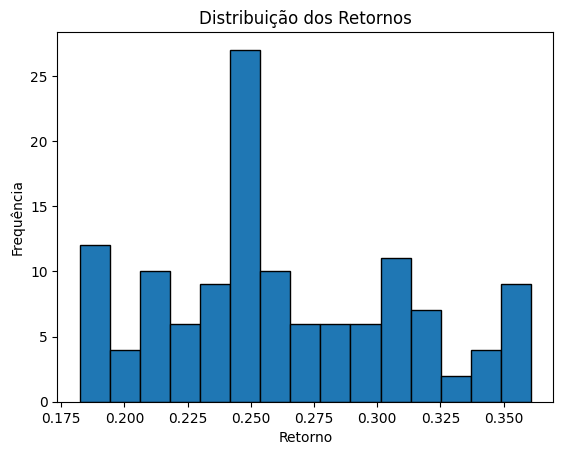

In [21]:
# Display basic statistics for the Retorno column
print(var_df['Retorno'].dropna().describe())

# Plot the distribution of returns to visualize the data
import matplotlib.pyplot as plt
plt.hist(var_df['Retorno'].dropna(), bins=15, edgecolor='black')
plt.title('Distribuição dos Retornos')
plt.xlabel('Retorno')
plt.ylabel('Frequência')
plt.show()